# Projet 3: Concevez une application au service de la santé publique

- Notre mission est de **concevoir une application au service de la santé publique en lien avec l'alimentation**.
- Cet exercice est fait à partir de la base de données **OpenFoodFacts** qui fournit des information nutritionnelle.



## 1. Notre idée d'application

Notre application scan un produit alimentaire et recommande une liste de produits riches en protéines avec moins d'additifs. Cette recommandation sert renforcer la santé des **OS** et ainsi prevenir l'**ostéoporose** chez les adultes.

## 2. Analyse Exploratoire des données
- 2.1. Chargement des librairies,
- 2.2. Importation des données,
- 2.3. Description des données,
- 2.4. Nettoyage des données,
- 2.5. Choix des variables pertinentes
- 2.6. Detection et suppression des outliers,
- 2.7. Detection et traitement des valeurs aberrantes,
- 2.8. Detection et traitement des valeurs manquantes.


### 2.1. Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn import decomposition, preprocessing
from wordcloud import WordCloud, STOPWORDS
import math
import pickle
# style
plt.style.use("ggplot")
#rcParams['figure.figsize'] = (12,  6)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

### 2.2. Importation des données


In [2]:
data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_2680/1731453773.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


 ### 2.3. Description du jeu de données

Nous avons 162 variables

In [3]:
data.shape

(320772, 162)

Nous observons 320772 lignes et 162 colonnes dont 56 representent des chaines de caracteres et 106 colonnes sont numériques. Les variables numeriques représentent des éléments nutritifs. Ces produits alimentaires sont classés selon leur grade nutritionnel de "a" à "e". Un grade qui est lui-même fonction d'un score sythétique basé sur la teneur en nutriments.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [6]:
data.dtypes;

- <span style='background:aqua'>**Recherche de variables manquantes (en %)**</span>

In [7]:
data.isna().mean().sort_values(ascending = True);

- <span style='background:aqua'>**Visualisation des valeurs manquantes**</span>

Text(0.5, 1.0, 'Répartition des valeurs manquantes')

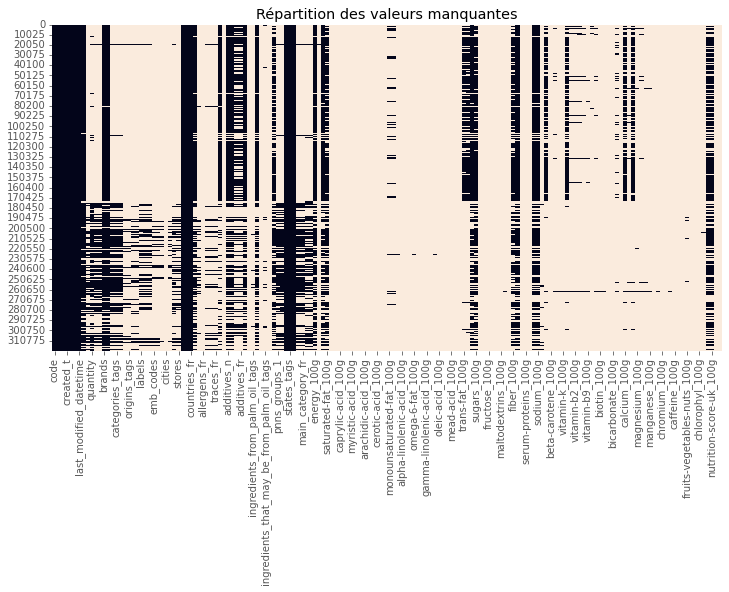

In [10]:
rcParams['figure.figsize'] = (12,  6)
p = sns.heatmap(data.isna(), cbar=False)
p.set_title("Répartition des valeurs manquantes")

In [4]:
# percentage de données manquantes 
NaN_col = data.isnull().mean() * 100
NaN_col.describe()

count    162.000000
mean      76.221573
std       34.560501
min        0.000000
25%       56.437906
50%       97.967871
75%       99.991427
max      100.000000
dtype: float64

- <span style='background:aqua'>**le nombre de produit par pays**</span>

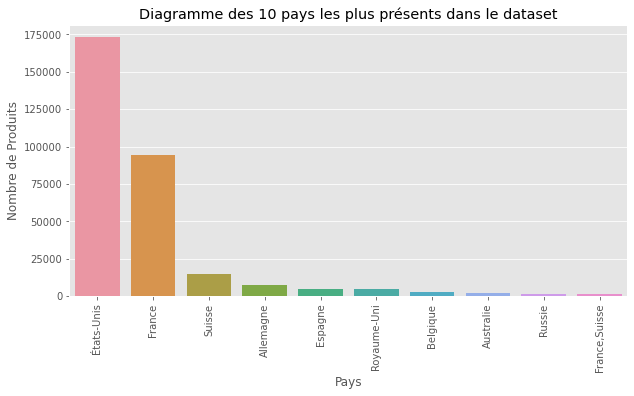

In [30]:
df_countries = data["countries_fr"].value_counts()
df_countries = df_countries.where(df_countries>1).dropna()

# Les 10 pays les plus représentés
plt.figure(figsize=(10,5))
sns.barplot(x = df_countries.index[:10],
           y = df_countries.tolist()[:10])
plt.xlabel('Pays')
plt.ylabel('Nombre de Produits')
plt.title('Diagramme des 10 pays les plus présents dans le dataset')
plt.xticks(rotation=90)
plt.show()

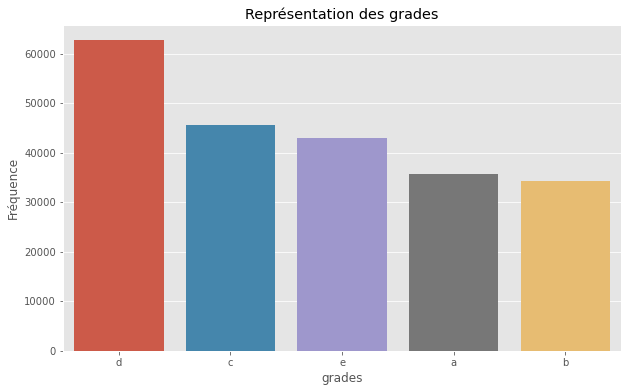

In [26]:
df_grades = data["nutrition_grade_fr"].value_counts()
df_grades = df_grades.where(df_grades>1).dropna()

plt.figure(figsize=(10,6))
sns.barplot(x = df_grades.index,
           y = df_grades.values)
plt.xlabel('grades')
plt.ylabel('Fréquence')
plt.title('Représentation des grades')
plt.show()

- <span style='background:aqua'>**Nous nous interessons aux produits vendu en France pour cette étude** </span>

In [9]:
fr_data = data[data['countries_tags'].str.contains('en:france', case=False, na=False)]
fr_data.shape

(98439, 162)

- <span style='background:aqua'>**Valeurs manquantes dans les données "france_data"**</span> 

Text(0.5, 1.0, 'Répartition des valeurs manquantes')

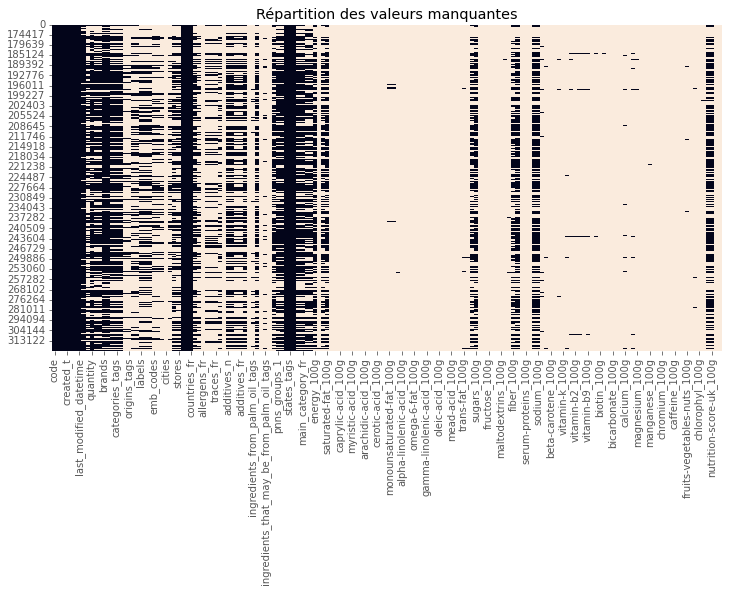

In [13]:
rcParams['figure.figsize'] = (12,  6)
p = sns.heatmap(fr_data.isna(), cbar=False)
p.set_title("Répartition des valeurs manquantes")

### 2.4. Nettoyage des données

- <span style='background:aqua'>**Valeurs manquantes en %**</span> 

In [10]:
fr_data.isna().mean().sort_values(ascending = True);

- <span style='background:aqua'>**Concerver les variables qui ont moins de 75% de valeur manquantes**</span> 

In [11]:
fr_data=fr_data[fr_data.columns[fr_data.isna().mean() < 0.75]]
fr_data.shape

(98439, 56)

In [12]:
fr_data.head();

### 2.5. Choix des variables pertinentes
Pour éviter l'ostéoporose, il faut consommer des aliments saints, équilibrés et riches en protéines avec **moins d'additifs**.
Pour les **produits disponibles en France** nous retenons les variables suivantes:
- **code** : identifiant unique du produit
- **additives**
- **image_url** : la photographie aide à reconnaître le produit
- **product_name** : le nom du produit
- **pnns_groups_1** : premier groupe de classement
- **pnns_groups_2** : le produit est-il autorisé, interdit etc...
- **brands** : la marque du produit
- **main_category_fr**: la categorie du produit.
- **Des nutriments**

In [13]:
key_file = fr_data.copy()

### <span style='background:Yellow'>**Notre selection des données**</span> 

In [14]:
data_france = key_file[['code', 'product_name', 'image_url', 'brands', 'additives_n',
       'ingredients_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'main_category_fr', 
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'nutrition-score-fr_100g']]

In [15]:
data_france.shape

(98439, 19)

In [16]:
data_france.describe();

- <span style='background:aqua'>**Visualisation des données manquantes**</span> 

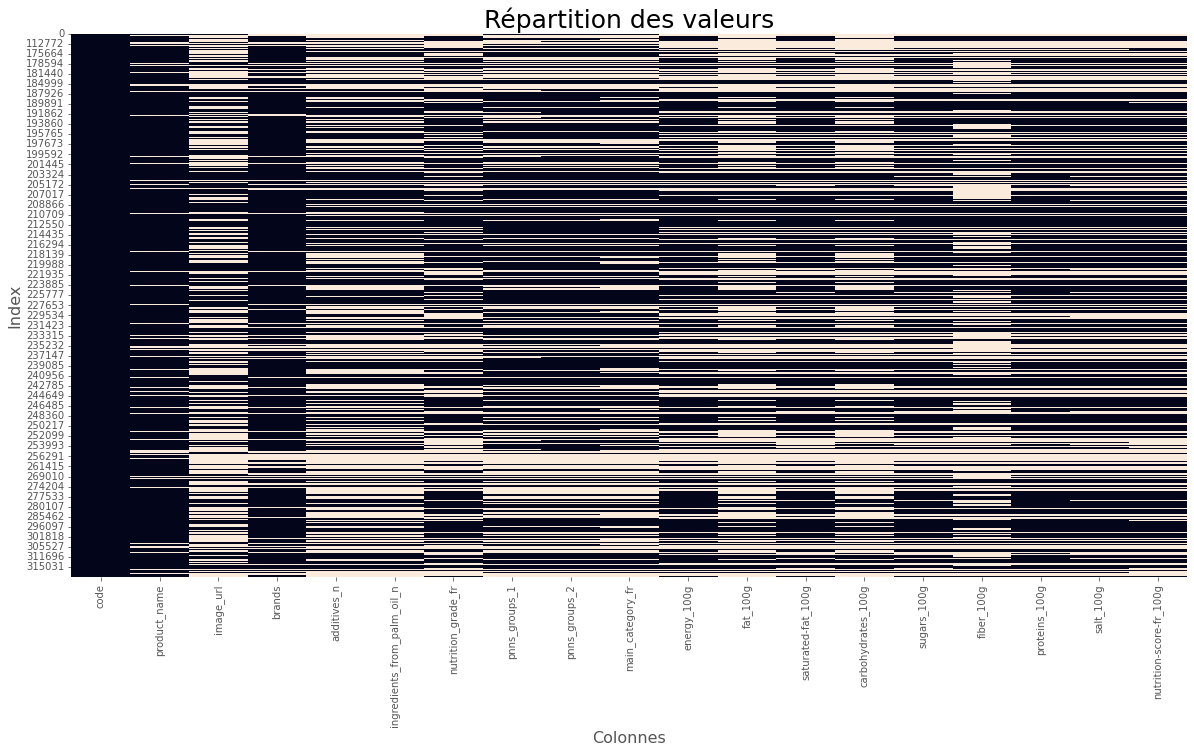

<Figure size 864x432 with 0 Axes>

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(data_france.isna(), cbar=False)
plt.title('Répartition des valeurs',size=25)
plt.xlabel("Colonnes", size=16)
plt.xticks(rotation=90)
plt.ylabel("Index",size=16)
plt.show()
plt.savefig('Répartition des valeurs')

- <span style='background:aqua'>**Visualisation des données manquantes par quantité**</span>

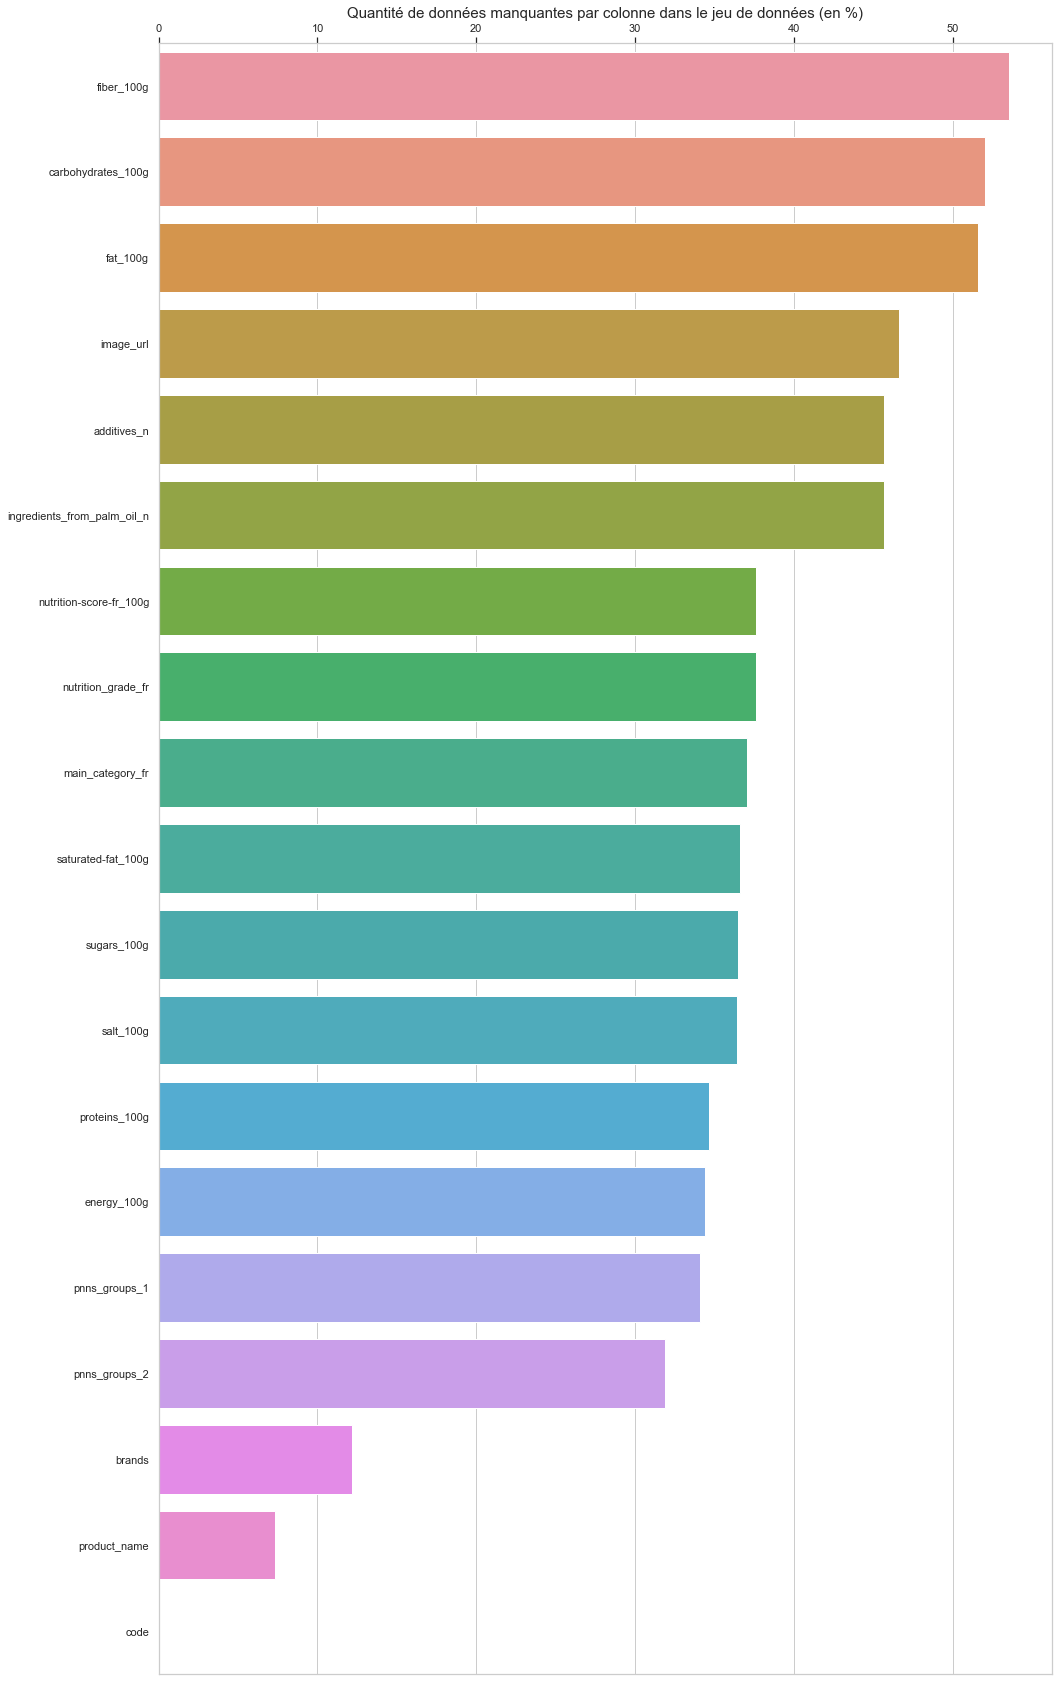

In [23]:
proportion_nan = data_france.isna().sum().divide(data_france.shape[0]/100).sort_values(ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(16, 30))
ax = sns.barplot(y = proportion_nan.index, x=proportion_nan.values)
ax.xaxis.set_ticks_position('top')
plt.title('Quantité de données manquantes par colonne dans le jeu de données (en %)', size=15)
plt.show()

In [17]:
data_france.dtypes;

## 2.6. Detection et suppression des outliers

- <span style='background:aqua'>**Création d'une variable regroupant toutes les colonnes numériques**</span>

In [18]:
feature = data_france.select_dtypes("float")
feature.columns;

- <span style='background:aqua'>**Function pour detecter les outliers**</span>

In [19]:
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    
    ls = df.index[ (df[ft] < lower_range) | (df[ft] > upper_range) ]
    return ls

- <span style='background:aqua'>**Liste des outliers**</span>

In [20]:
index_list = []
for col in feature.columns:
    index_list.extend(outliers(data_france, col))
index_list;

- <span style='background:aqua'>**Fonction pour supprimer les outliers**</span>

In [22]:
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [23]:
data_france_cleaned = remove(data_france, index_list)

In [24]:
print(data_france_cleaned.shape)
print(data_france.shape)

(77027, 19)
(98439, 19)


### <span style='background:Yellow'>**Detection outliers**</span>

<AxesSubplot:xlabel='energy_100g'>

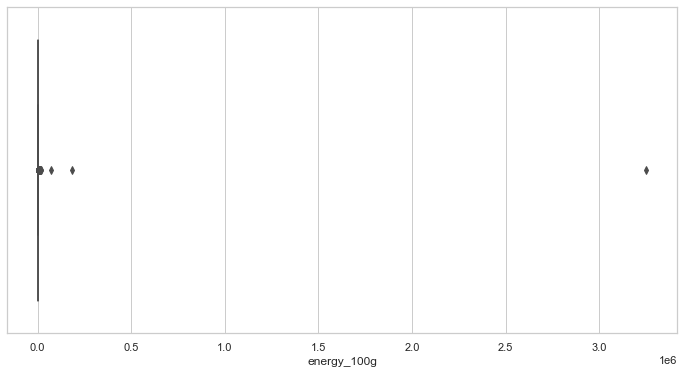

In [32]:
sns.boxplot(x=data_france["energy_100g"])

### <span style='background:Yellow'>**Outliers supprimés**</span>

<AxesSubplot:xlabel='energy_100g'>

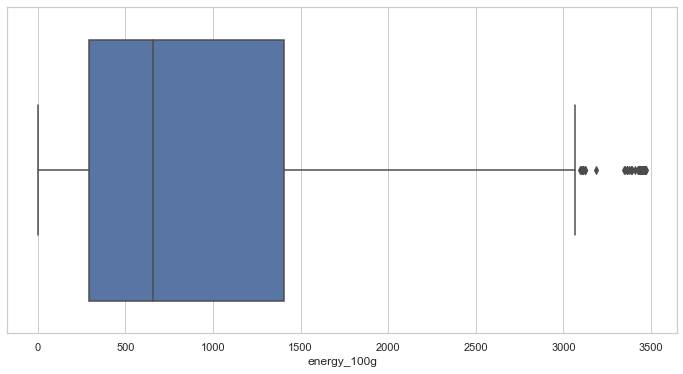

In [33]:
sns.boxplot(x=data_france_cleaned["energy_100g"])

## 2.7. Detection et suppression des valeurs aberrantes 

### <span style='background:Yellow'>**Cas des variables numériques**</span>

Conditions d'identification des valeurs aberrantes:

- Les **produits avec des valeurs >100** dans au moins l'une des colonnes **[*_100g]**
- Les **produits avec des valeurs négatives** dans au moins l'une des colonnes **[*_100g]**
- Les **produits avec carbohydrates_100g > sugars_100g**
- Les **produits avec saturated-fat_100g > fat_100g**
- Les **produits avec la valeur 'energy_100g' anormalement élevé**

In [78]:
data_france_cleaned.describe();

### <span style='background:Yellow'>**Cas des variables categorielles**</span>

In [79]:
df_fr = data_france_cleaned.copy()

<span style='background:aqua'>**code**</span>

In [80]:
# Detection de doublons
doublons_code = df_fr[df_fr.duplicated(['code'], keep=False)]
nb_doublons_code = doublons_code.shape[0]
print( f'Nombre de doublons sur le code produit : {int(nb_doublons_code/2)}')

Nombre de doublons sur le code produit : 4


<span style='background:aqua'>**pnns_groups_1/pnns_groups_2**</span>

In [81]:
df_fr.groupby('pnns_groups_1')[['product_name']].count()

,product_name
pnns_groups_1,
Beverages,6052
Cereals and potatoes,4952
Composite foods,5079
Fat and sauces,2064
Fish Meat Eggs,5372
Fruits and vegetables,3681
Milk and dairy products,4816
Salty snacks,1458
Sugary snacks,3928


In [82]:
df_fr.groupby('pnns_groups_1')[['product_name']].count().sort_values(by='product_name')

,product_name
pnns_groups_1,
cereals-and-potatoes,2
sugary-snacks,377
fruits-and-vegetables,530
Salty snacks,1458
Fat and sauces,2064
Fruits and vegetables,3681
Sugary snacks,3928
Milk and dairy products,4816
Cereals and potatoes,4952


**Remarque** 
- Aucune valeur aberrante.
- Beaucoup de valeurs non renseignées

<span style='background:aqua'>**Brands**</span>

In [83]:
df_fr.groupby('brands')[['product_name']].count().sort_values(by='product_name').sort_values(by='product_name', ascending=False).head(15)

,product_name
brands,
Carrefour,2031
Auchan,1709
U,1555
Casino,1249
Leader Price,1240
Picard,791
Cora,710
Monoprix,581
Fleury Michon,480


**Remarque** 
- Aucune valeur aberrante.


<span style='background:aqua'>**image_url - Doublons**</span>

In [84]:
doublons_img = df_fr[data_france.duplicated(['image_url'], keep=False)]
nb_doublons_img = doublons_img[doublons_img['image_url'].notnull()].shape[0]
print(f'Nombre de doublons sur la photographie du produit : {nb_doublons_img}')

Nombre de doublons sur la photographie du produit : 0


/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_56178/4065361655.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  doublons_img = df_fr[data_france.duplicated(['image_url'], keep=False)]


In [85]:
df_fr['image_url'].isna().sum()

36890

**Remarque** 
- Aucune valeur aberrante.


<span style='background:aqua'>**product_name**</span>

on remarque il y a des produits dont les noms font moins de 3 caractères.

In [86]:
df_fr[df_fr['product_name'].str.len() < 3];

- **Suppression des produits avec taille des noms < 3 caractères**

In [87]:
df_fr.drop(df_fr[df_fr['product_name'].str.len() < 3].index);

**Remarque** :supprimer les produits dont les noms font moins de 3 caractères.

<span style='background:aqua'>**nutrition_grade_fr**</span>

In [88]:
df_fr['nutrition_grade_fr'].unique()

array([nan, 'e', 'd', 'c', 'a', 'b'], dtype=object)

In [89]:
# Passer en majuscules
df_fr['nutrition_grade_fr'] = df_fr['nutrition_grade_fr'].str.upper().apply(str)
df_fr['nutrition_grade_fr'].unique()

array(['nan', 'E', 'D', 'C', 'A', 'B'], dtype=object)

## 2.8. Traitements des données manquantes

### <span style='background:Yellow'>**Remplacer les valeurs manquantes par la mediane en fonction de la colonne **pnns_group_1.**</span> 

In [90]:
df_fr.pnns_groups_1.value_counts()

unknown                    9566
Beverages                  6101
Fish Meat Eggs             5400
Composite foods            5097
Cereals and potatoes       4975
Milk and dairy products    4834
Sugary snacks              3972
Fruits and vegetables      3694
Fat and sauces             2082
Salty snacks               1466
fruits-and-vegetables       530
sugary-snacks               378
cereals-and-potatoes          2
Name: pnns_groups_1, dtype: int64

- Filtrage en fonction de la colonne 'pnns_groups_1' Non Null ET différent de 'unknown'

In [91]:
df_group_1 = df_fr[(df_fr.pnns_groups_1.notnull()) & (df_fr.pnns_groups_1 != 'unknown')]

<span style='background:aqua'>**Fonctions de remplissage des données manquantes en fonction de la mediane.**</span> 

In [92]:
def fillMissingValues(df, cols, categ):
  for categorie in df[categ].unique():
    df.loc[df[categ]==categorie, cols] = df[df[categ]==categorie][cols].fillna(df[df[categ] == categorie][cols].median())
  return df

In [93]:
cols = df_fr.select_dtypes("float")

<span style='background:aqua'>**Remplissage des données manquantes des colonnes [*_100g]  à partir des médianes et en fonction de la colonne 'pnns_groups_1.'**</span>

In [94]:
columns_ = ['additives_n', 'ingredients_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g']
df_fr = fillMissingValues(df_group_1, columns_, 'pnns_groups_1')

- <span style='background:aqua'>**Suppression des données manquantes pour product_name.**</span> 

In [95]:
df_fr.dropna(subset=['product_name', 'image_url', 'brands'], inplace=True)

### <span style='background:Yellow'>**Traitements des données manquantes pour nutrition_score et nutrition_grade.**</span> 

Ces 2 colonnes étant étroitement corrélées. Connaissant le nutrition-grade d'un produit, si son nutrition-score est manquant, on l'imputera avec la moyenne des nutrition-score dont le nutrition-grade est le même.

In [96]:
def imputationForNutriScoreAndGrade(data, quanti, nutri_grade):
    # Avant d'imputer les valeurs manquantes de nutrition-grade (qui sont des valeurs qualitatives),
    #on encode les valeurs pour qu'elles soient numériques
    le = preprocessing.LabelEncoder()
    le.fit(data['nutrition_grade_fr'])
    data['nutrition_grade_fr'] = np.where(le.transform(data['nutrition_grade_fr']) == 5, 
                                          np.nan, le.transform(data['nutrition_grade_fr']))

    data_quanti = data[quanti + nutri_grade].copy()

    # Ici on impute les valeurs manquantes pour nutrition-grade en utilisant le knn
    imputer = KNNImputer(n_neighbors=5)
    data_quanti[quanti + nutri_grade] = imputer.fit_transform(data_quanti[quanti + nutri_grade])

    data_quanti['nutrition_grade_fr'] = data_quanti['nutrition_grade_fr'].apply(math.floor)
    
    # On décode les valeurs de nutrition-grade pour retrouver les valeurs sous formes qualitatives (de A à E)
    data_quanti['nutrition_grade_fr'] = le.inverse_transform(data_quanti['nutrition_grade_fr'])

    data[quanti + nutri_grade] = data_quanti.copy()

    nutrition_grade_map = {}
    # On ajoute dans un dictionnaire chaque valeur du nutri-grade avec la moyenne des nutri-score associés
    for value in data['nutrition_grade_fr'].unique():
        nutrition_grade_map[value] = data['nutrition-score-fr_100g'][data['nutrition_grade_fr'] == value].mean()

    # On impute les valeurs manquantes de nutrition-score avec la moyenne coresspondant au bon nutrition-grade
    for index in data.index:
        if str(data['nutrition-score-fr_100g'][index]) == 'nan':
            data['nutrition-score-fr_100g'][index] = nutrition_grade_map[data['nutrition_grade_fr'][index]]

    return data.copy()


In [97]:
nutri_score = ['nutrition-score-fr_100g']
nutri_grade = ['nutrition_grade_fr']

# Imputation des colonnes 'nutrition_grade_fr' et 'nutrition-score-fr_100g'
data_selection_clean =  imputationForNutriScoreAndGrade(df_fr, columns_, nutri_grade)

/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_56178/4044949998.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nutrition-score-fr_100g'][index] = nutrition_grade_map[data['nutrition_grade_fr'][index]]


In [98]:
data_selection_clean.columns

Index(['code', 'product_name', 'image_url', 'brands', 'additives_n',
       'ingredients_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_1',
       'pnns_groups_2', 'main_category_fr', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [99]:
data_selection_clean['nutrition_grade_fr']

182       A
184       C
188       A
226       E
240       E
         ..
320749    B
320751    A
320758    C
320763    C
320765    B
Name: nutrition_grade_fr, Length: 28166, dtype: object

### <span style='background:Yellow'>**Base de données finale.**</span> 

In [100]:
df_fr_final = data_selection_clean.copy()

In [101]:
df_fr_final.shape

(28166, 19)

In [102]:
df_fr_final.dropna(how='all', inplace=True)

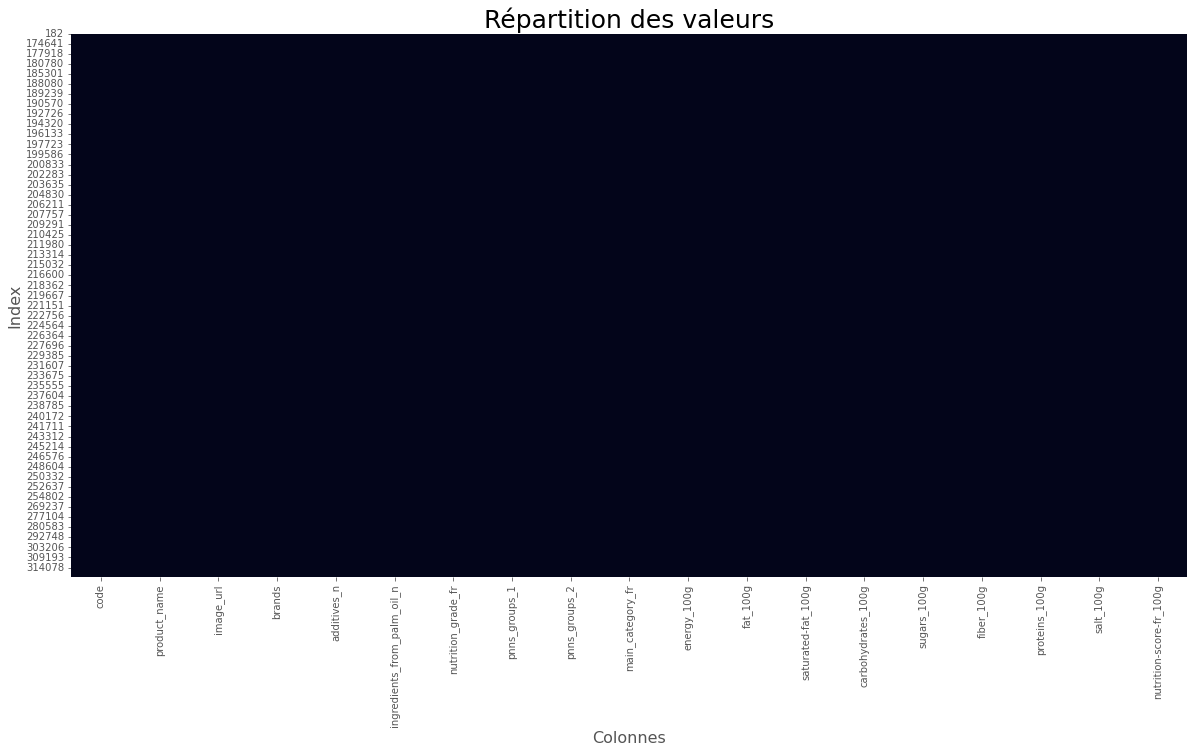

<Figure size 432x288 with 0 Axes>

In [103]:
plt.figure(figsize=(20,10))
sns.heatmap(df_fr.isna(), cbar=False)
plt.title('Répartition des valeurs',size=25)
plt.xlabel("Colonnes", size=16)
plt.xticks(rotation=90)
plt.ylabel("Index", size=16)
plt.show()
plt.savefig('Répartition des valeurs')

In [104]:
df_fr_final.drop('ingredients_from_palm_oil_n', axis=1, inplace=True)

In [105]:
df_fr_final.to_csv('Cleaned_Food_df.csv', sep='\t',index=False)